In [153]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import rotate
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import signal


def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.max(G)

plt.gray()

lena= rgb2gray(imread('lena2.tiff'))
frequnoisy = imread('frequnoisy.tif').astype(np.float64)/255

<Figure size 640x480 with 0 Axes>

**Part 2 - Fourier Analysis**

Text(0.5, 1.0, 'Test Image')

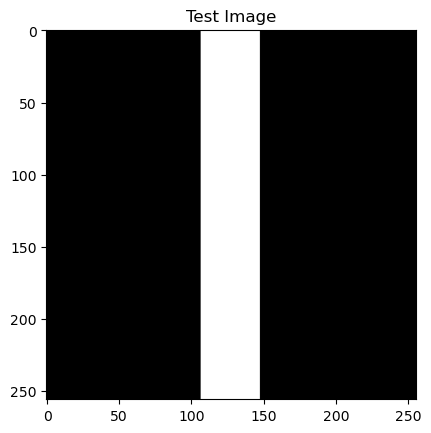

In [154]:
# original test image (vertical white bar on black background)
f = np.zeros((256,256))
f[:,107:148] = 1

plt.figure()
plt.imshow(f)
plt.title('Test Image')


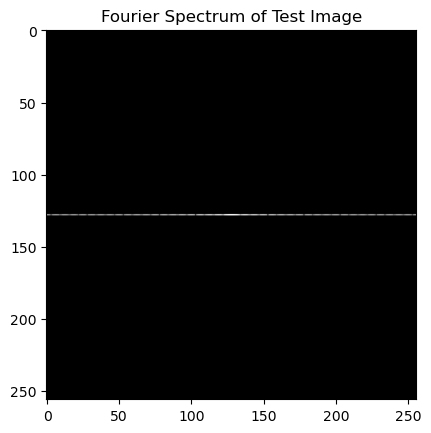

In [155]:
# fourier spectrum of the test image
F = np.fft.fftshift(np.fft.fft2(f))
plt.figure()
plt.imshow(np.log(1+np.abs(F)), cmap='gray')
plt.title('Fourier Spectrum of Test Image')
plt.show()

**1. What can you say about the general distribution of energy in the Fourier spectra? Why?**

It seems that most of the energy is concentrated at the center of the Fourier spectrum. This is because the pixel intensities are mostly constant, with a couple sharp transitions at the edges of the white rectangle. This image contains mostly low frequency components which is represents in the frequency domain with slow and smooth variations.

**2. What characteristics about the test image can you infer from the Fourier spectra?**

The orientation of the rectangle can be predicted since the spectrum is showing horizontal bands, indicating that there are strong horizontal frequency components, as would be seen in a vertical rectangle. The sharpness of the rectangle edges can also be interpreted from the brightness fading away from the center in the Fourier spectrum.

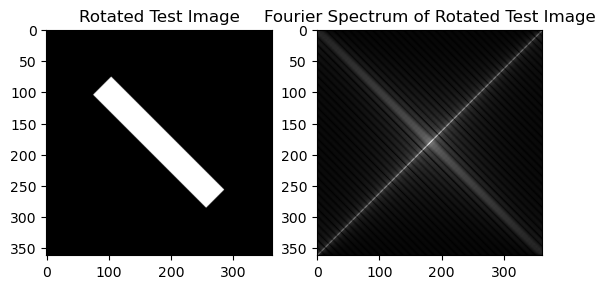

In [156]:
# rotated image fourier spectrum
f_rotated = rotate(f, 45, resize=True)
F_rotated = np.fft.fftshift(np.fft.fft2(f_rotated))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(f_rotated)
plt.title('Rotated Test Image')

plt.subplot(1,2,2)
plt.imshow(np.log(1+np.abs(F_rotated)), cmap='gray')
plt.title('Fourier Spectrum of Rotated Test Image')
plt.show()

**3. How did the Fourier spectra change from the original image (before rotation)?**

When you rotate the test image by 45°, the Fourier spectrum also rotates by the same angle. The energy spectrum is still concentrated at the spectrum, and less concentrated the further you go out. 

**4. What conclusions and observations can be made about image characteristics based on the Fourier spectra of both original image and the rotated image?**

The orientation of structures in the image directly corresponds to the orientation of patterns in the Fourier spectrum, as they are rotated by the same angle. In terms of spectra energy location, the spread stays the same, clarifying that frequency content is not varied, only it's rotation.


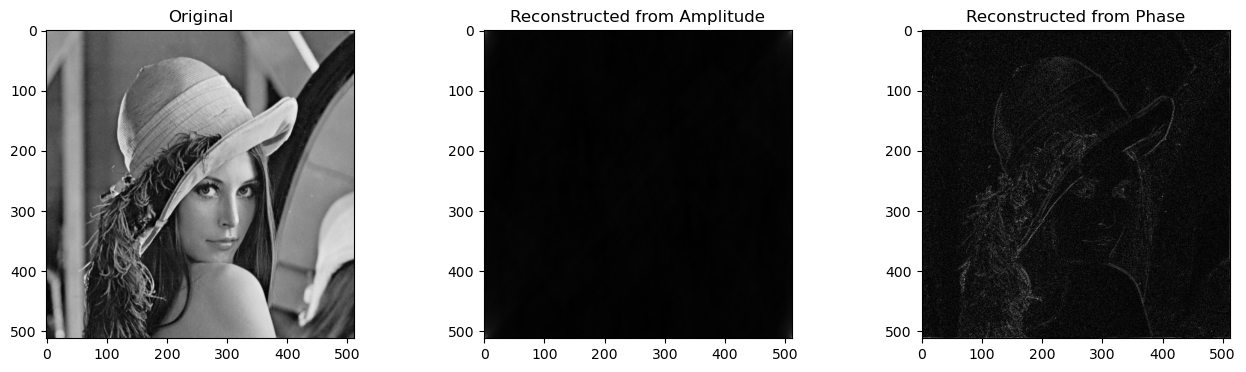

<Figure size 640x480 with 0 Axes>

In [157]:
L = np.fft.fftshift(np.fft.fft2(lena))
A = np.abs(L)
theta = L / A

reconstructed_amp = np.fft.ifft2(np.fft.ifftshift(A)).real
reconstructed_theta = np.fft.ifft2(np.fft.ifftshift(theta)).real

plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.imshow(lena)
plt.title('Original')        
plt.subplot(1,3,2)
plt.imshow(reconstructed_amp)
plt.title('Reconstructed from Amplitude')
plt.subplot(1,3,3)
plt.imshow(np.abs(reconstructed_theta))
plt.title('Reconstructed from Phase')
plt.show()
plt.tight_layout()

**5. Describe how the reconstructed image from the amplitude component look like?**
**What image characteristics does the amplitude component capture?**

The amplitude component is not good at capturing any image components. This makes sense as the spatial information is all gone in the reconstructed amplitude image. 

**6. Describe how the reconstructed image from the phase component look like? What image characteristics does the phase component capture?**
The phase spectrum gives information on the edges in the lena image. The phase component captures the shapes, edges and contours in the image. 

**Part 4 - Filter Design**

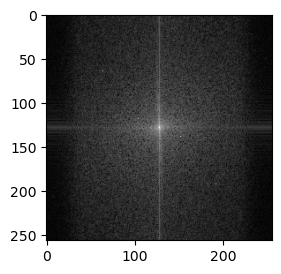

In [158]:
# fft of noisy frequency image
F_noisy = np.fft.fftshift(np.fft.fft2(frequnoisy))
mag_F_noisy = np.log1p(np.abs(F_noisy))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mag_F_noisy, cmap='gray')

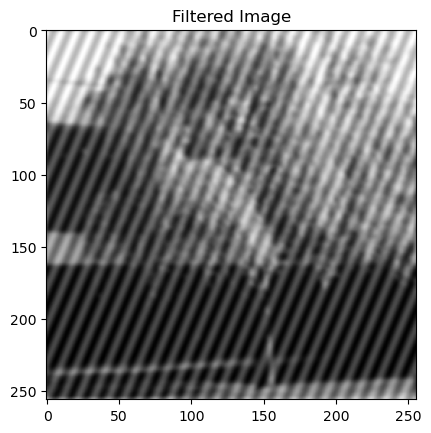

In [159]:
# the spectrum above shows one high energy peak at the center, that spans both horizontal and vertical directions.
# a filter that blocks these frequencies would be ideal to remove the noise.

# step 1: design a low-pass Gaussian filter
n_rows, n_cols = frequnoisy.shape
G_LP = gaussian_filter(n_rows, n_cols, stdv=30) # larger stdv for smoother image

F_filtered = F_noisy * G_LP
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real

plt.imshow(f_filtered, cmap='gray')     
plt.title('Filtered Image')
plt.show()      

This image removes som of the noise, but clearly blurs the image too much, hence maybe a Gaussian filter is not adequete. Next we will try a notch reject filter, to only supress the noise around the mean and variance

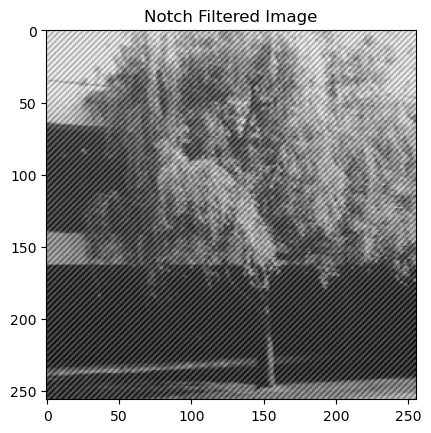

In [160]:
# step 2: design a notch reject filter to remove the noise frequency only
def notch_reject_filter(shape, u0, v0, D0=10):
    M, N = shape
    U, V = np.meshgrid(np.arange(-N//2, N//2), np.arange(-M//2, M//2))
    D1 = np.sqrt((U - u0)**2 + (V - v0)**2)
    D2 = np.sqrt((U + u0)**2 + (V + v0)**2)
    H = 1 / (1 + (D0**2 / (D1 * D2 + 1e-5)))  
    return H


center = np.array(mag_F_noisy.shape) // 2
magnitude_centered = mag_F_noisy.copy()
magnitude_centered[center[0]-10:center[0]+10, center[1]-10:center[1]+10] = 0  # ignore center peak

# find noise frequency peak
v0, u0 = np.unravel_index(np.argmax(magnitude_centered), magnitude_centered.shape)
u0_offset = u0 - center[1]
v0_offset = v0 - center[0]

H = notch_reject_filter(frequnoisy.shape, u0_offset, v0_offset, D0=1)

F_filtered = F_noisy * H
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
plt.imshow(f_filtered, cmap='gray')
plt.title('Notch Filtered Image')
plt.show()



The above image does a good job at removing the brightness and limiting the thickness of the diagnol noise bands, combining this notch filter with the gaussian should be effective in removing the noise artifacts all together.

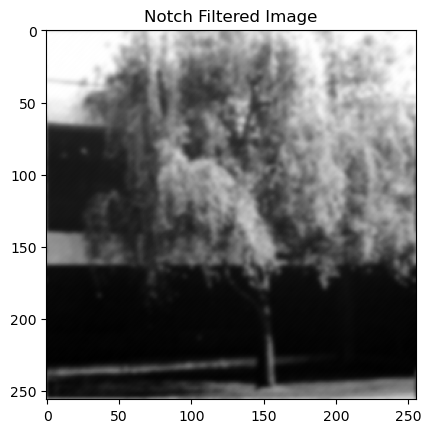

In [161]:
H_total = H * G_LP

F_filtered = F_noisy * H_total
f_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
plt.imshow(f_filtered, cmap='gray')
plt.title('Notch Filtered Image')
plt.show()


The image above shows a well filtered image. This indicates that combining the low pass gaussian with the notch filter is good at removing the unwanted periodic noise. The notch takes care of removing the sharp stripe artifacts, while the gaussian filter takes care of smoothing the image, removing the unwanted artifacts totally.  